In [18]:
# 필요한 라이브러리를 임포트
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from keras import models
from keras.layers import Reshape, ZeroPadding2D, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import GlorotUniform, HeNormal

#made by jh

In [2]:
# 사용 가능한 GPU 수를 출력
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  4


In [33]:
# 사전에 저장된 데이터셋을 로드
with open("./ML2016/RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')
    
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print(snrs)
print(mods)

X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)



[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [34]:
# 데이터를 훈련용과 테스트용으로 분할
np.random.seed(2023)
n_examples = X.shape[0]

#전체 데이터셋 중 50%를 훈련 데이터로 사용
n_train = int(n_examples * 0.5)

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

#  레이블(라벨)을 원핫 인코딩된(숫자) 형태로 변환하기 위해 사용
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

220000


In [5]:
in_shp = list(X_train.shape[1:])
classes = mods


In [6]:
# 병렬 GPU 사용 설정
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [7]:
# 모델 구성
with strategy.scope():
    dr = 0.5 
    model = models.Sequential()
    model.add(Reshape(in_shp + [1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer=GlorotUniform()))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer=GlorotUniform()))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer=HeNormal(), name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense(len(classes), kernel_initializer=HeNormal(), name="dense2"))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                        

In [8]:
# 훈련 파라미터 설정
nb_epoch = 100     
batch_size = 1024  #1024 이상 설정 시 컴퓨터 꺼짐 현상 발생

In [21]:
# 모델 훈련

# 모델의 가중치를 저장할 파일 지정
filepath = 'cnn2_weight.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
    # EarlyStopping : 검증 손실이 일정 에폭 동안 개선되지 않을 경우 훈련을 조기에 중단하는 옵션
    # Model Checkpoint :각 에폭 후에 모델의 가중치를 저장하여, 나중에 모델 성능이 좋을 때의 가중치를 다시 사용할 수 있게 하는 옵션

# 훈련이 끝난 후, 최적의 가중치를 로드
model.load_weights(filepath)

Epoch 1/100
108/108 - 6s - loss: 1.3129 - val_loss: 1.2839 - 6s/epoch - 52ms/step
Epoch 2/100
108/108 - 5s - loss: 1.3087 - val_loss: 1.2784 - 5s/epoch - 50ms/step
Epoch 3/100
108/108 - 5s - loss: 1.3034 - val_loss: 1.2760 - 5s/epoch - 51ms/step
Epoch 4/100
108/108 - 5s - loss: 1.3017 - val_loss: 1.2768 - 5s/epoch - 49ms/step
Epoch 5/100
108/108 - 5s - loss: 1.2983 - val_loss: 1.2768 - 5s/epoch - 49ms/step
Epoch 6/100
108/108 - 5s - loss: 1.3005 - val_loss: 1.2840 - 5s/epoch - 49ms/step
Epoch 7/100
108/108 - 5s - loss: 1.2988 - val_loss: 1.2702 - 5s/epoch - 51ms/step
Epoch 8/100
108/108 - 5s - loss: 1.2940 - val_loss: 1.2714 - 5s/epoch - 49ms/step
Epoch 9/100
108/108 - 5s - loss: 1.2883 - val_loss: 1.2876 - 5s/epoch - 49ms/step
Epoch 10/100
108/108 - 5s - loss: 1.2890 - val_loss: 1.2755 - 5s/epoch - 49ms/step
Epoch 11/100
108/108 - 5s - loss: 1.2905 - val_loss: 1.2705 - 5s/epoch - 49ms/step
Epoch 12/100
108/108 - 5s - loss: 1.2842 - val_loss: 1.2681 - 5s/epoch - 50ms/step
Epoch 13/100


In [22]:
# 모델의 성능을 평가하고 출력
# evaluate 함수는 주어진 데이터와 라벨에 대해 모델의 손실값을 계산
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)


1.2677719593048096


In [23]:
# Confusion matrix를 출력하는 함수를 정의
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)  
    plt.colorbar()  
    tick_marks = np.arange(len(labels))  
    plt.xticks(tick_marks, labels, rotation=45) 
    plt.yticks(tick_marks, labels) 
    plt.tight_layout()  
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

In [24]:
# 테스트 데이터에 대한 예측을 수행
test_Y_hat = model.predict(X_test, batch_size=batch_size)

108/108 [==============================] - 1s 10ms/step


In [25]:
# Confusion matrix를 계산
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

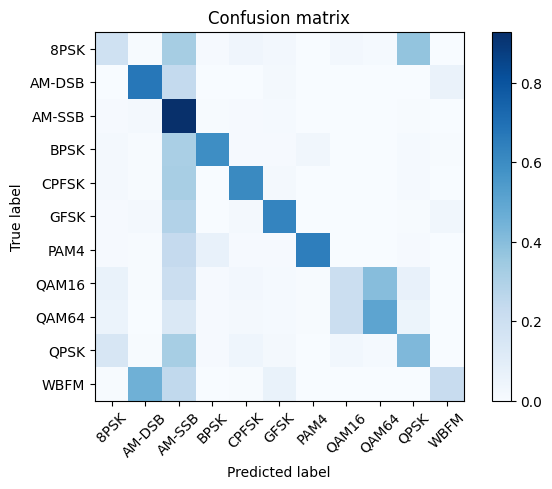

In [26]:
# Confusion matrix를 출력
plot_confusion_matrix(confnorm, labels=classes)

174/174 [==============================] - 1s 6ms/step
Overall Accuracy:  0.09387976168983571
176/176 [==============================] - 1s 6ms/step
Overall Accuracy:  0.08788471802170432
174/174 [==============================] - 1s 6ms/step
Overall Accuracy:  0.09704717320849839
171/171 [==============================] - 1s 6ms/step
Overall Accuracy:  0.10860805860805861
172/172 [==============================] - 1s 7ms/step
Overall Accuracy:  0.12818181818181817
173/173 [==============================] - 1s 6ms/step
Overall Accuracy:  0.21334297595371543
173/173 [==============================] - 1s 6ms/step
Overall Accuracy:  0.335201591032363
173/173 [==============================] - 1s 7ms/step
Overall Accuracy:  0.4959202175883953
172/172 [==============================] - 1s 7ms/step
Overall Accuracy:  0.6261818181818182
170/170 [==============================] - 1s 6ms/step
Overall Accuracy:  0.6918540361223737
171/171 [==============================] - 1s 6ms/step
Overall Ac

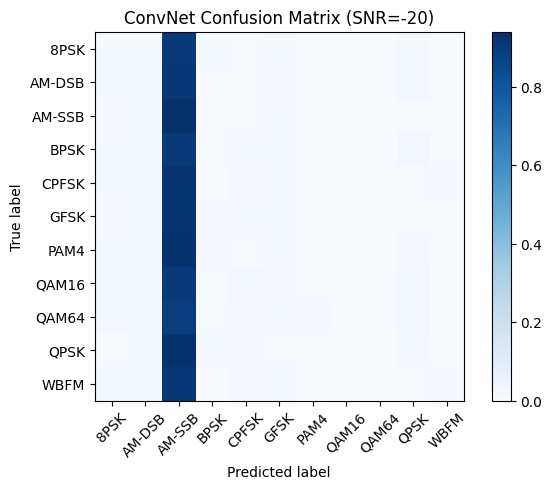

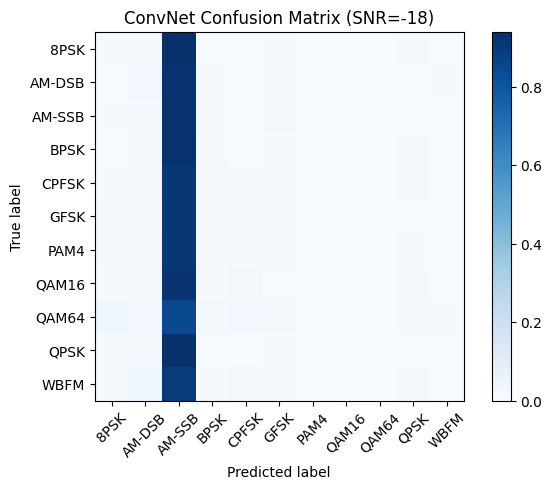

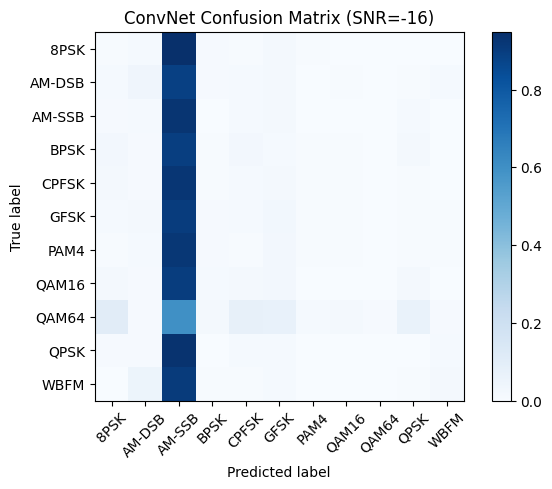

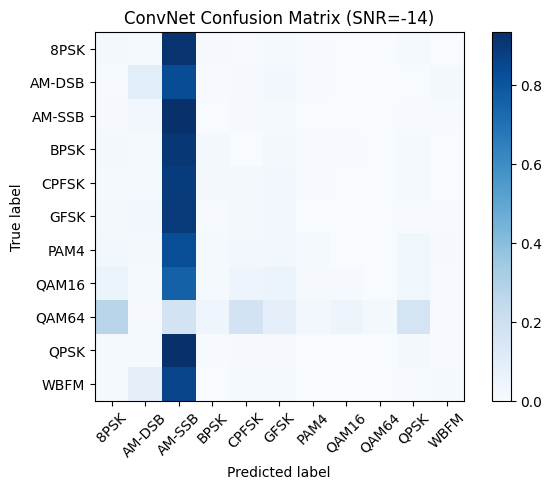

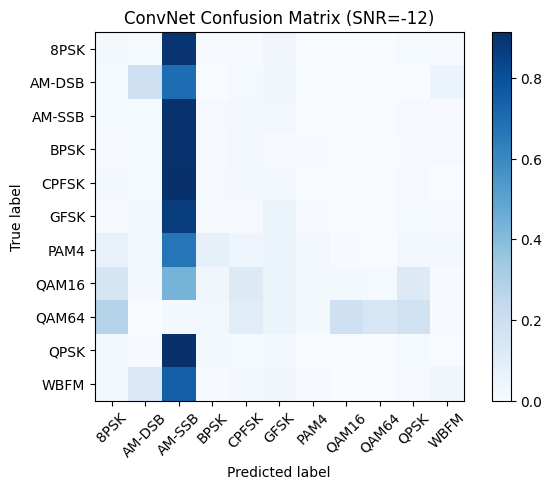

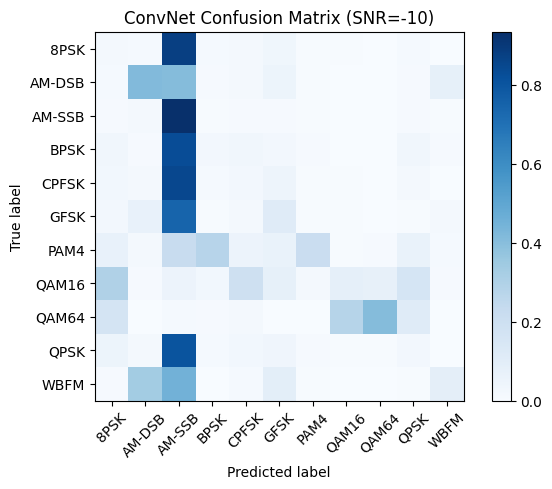

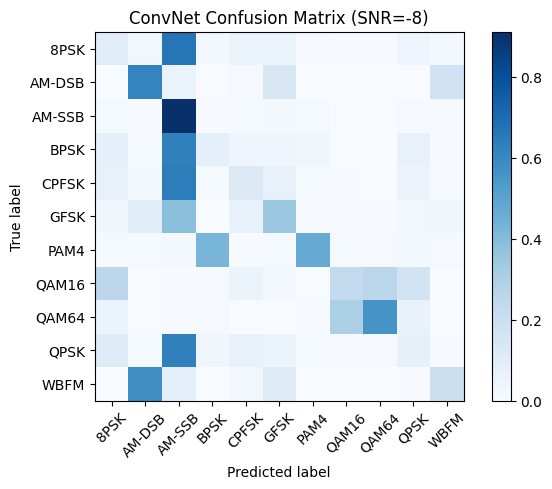

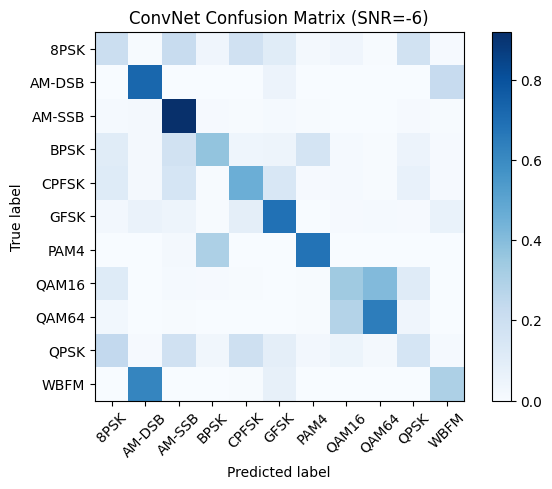

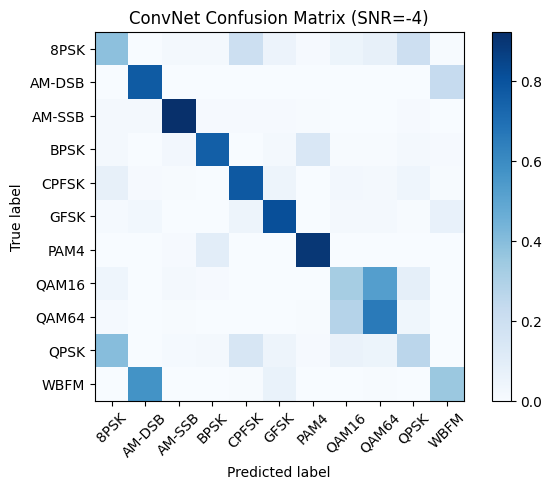

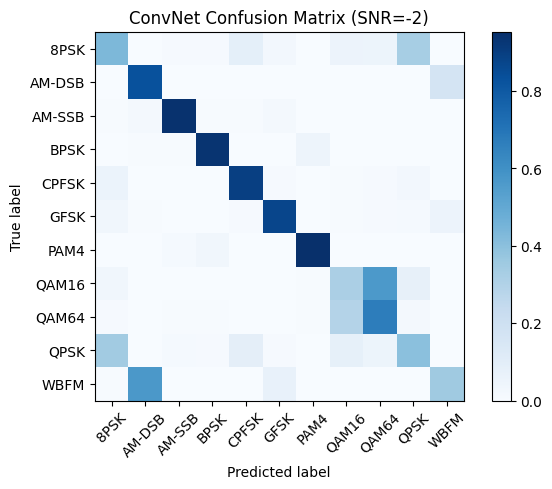

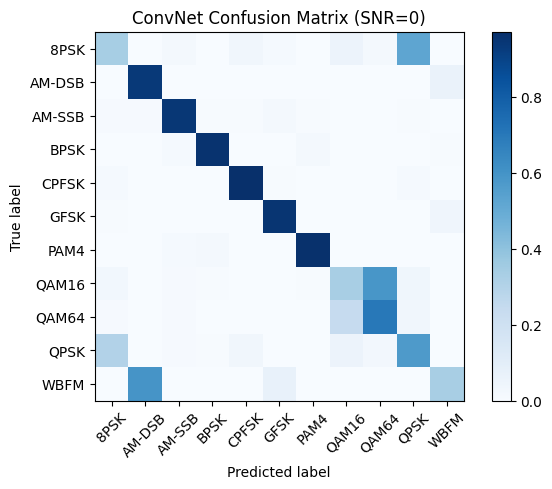

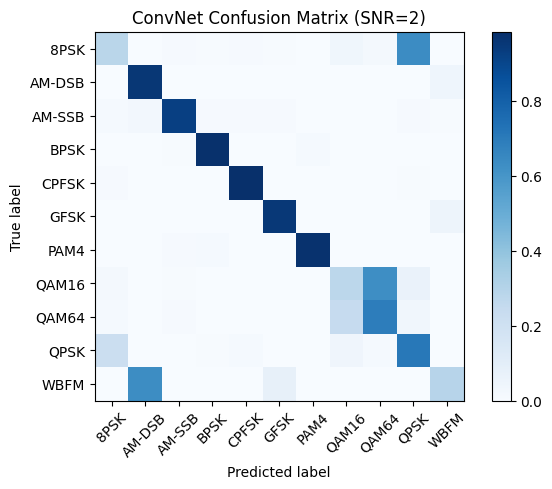

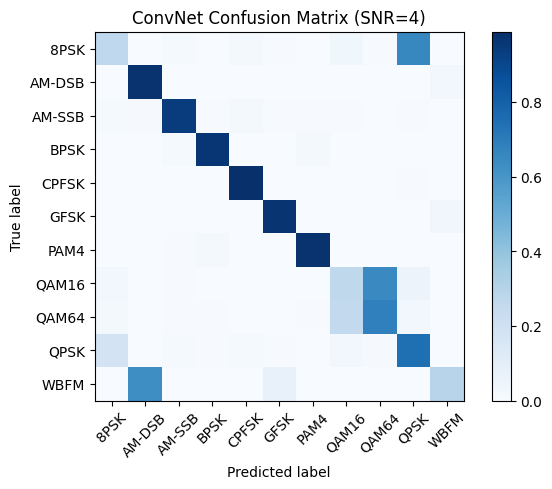

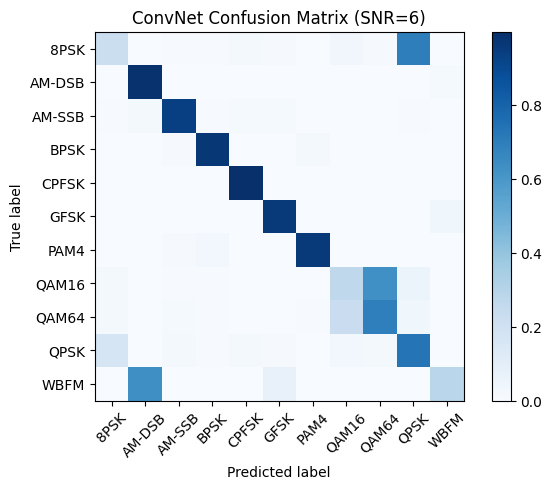

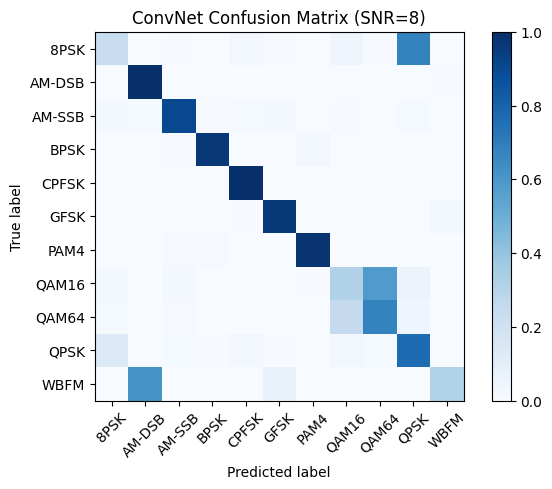

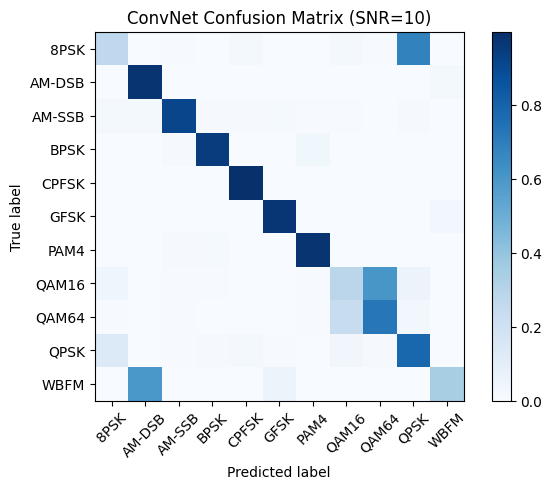

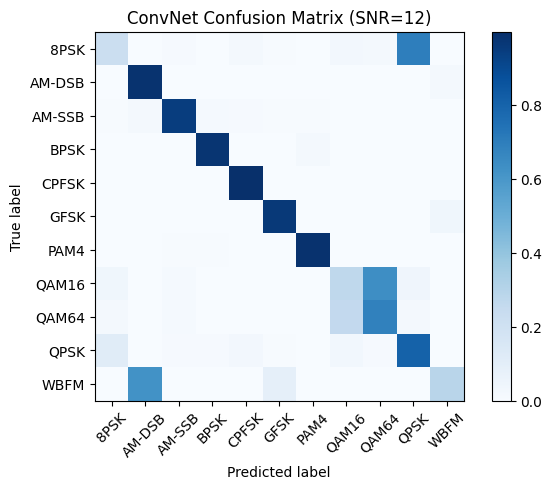

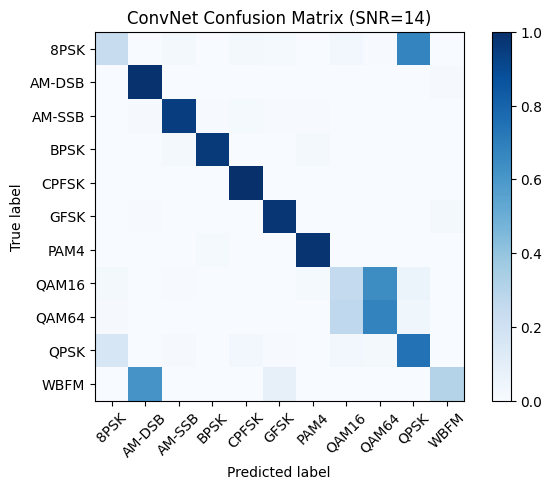

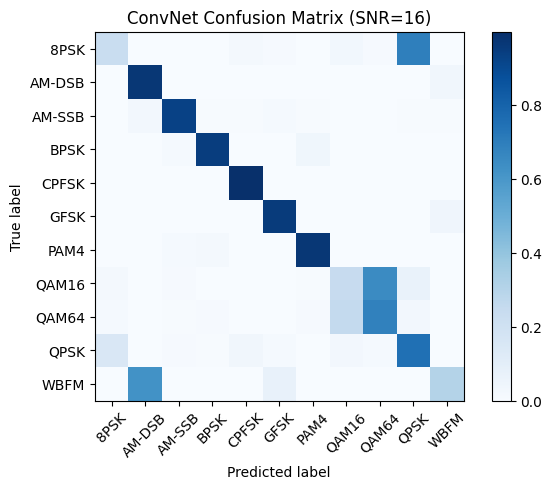

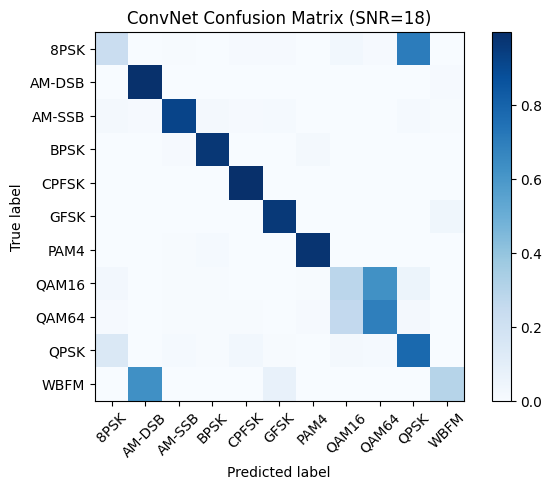

In [27]:
# SNR 별로 accuracy를 계산
acc = {}
for snr in snrs:
    # 해당 SNR에 대한 데이터 추출
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # 해당 SNR에 데이터가 있는지 확인
    if test_X_i.shape[0] > 0:
        # 클래스 예측
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        # Confusion matrix를 출력
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
        
        # 정확도를 계산하고 출력
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print ("Overall Accuracy: ", cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)
    else:
        print("No data for SNR =", snr)


In [28]:
# 결과를 pickle 파일로 저장
print (acc)
fd = open('cnn2_accuracy.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09387976168983571, -18: 0.08788471802170432, -16: 0.09704717320849839, -14: 0.10860805860805861, -12: 0.12818181818181817, -10: 0.21334297595371543, -8: 0.335201591032363, -6: 0.4959202175883953, -4: 0.6261818181818182, -2: 0.6918540361223737, 0: 0.7293880542323196, 2: 0.7257622786196823, 4: 0.7322791712104689, 6: 0.7258414766558089, 8: 0.7363805970149254, 10: 0.7426137393510966, 12: 0.7369001654715941, 14: 0.7315279770444764, 16: 0.730790390610673, 18: 0.7341795104261106}


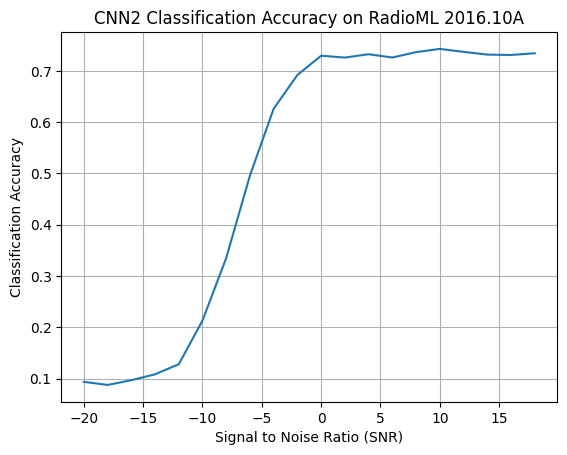

In [30]:
# SNR에 따른 정확도를 플롯
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio (SNR)")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10A")
plt.grid(True)
plt.show()